# Import and setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import few

from few.trajectory.inspiral import EMRIInspiral
from few.trajectory.ode import SchwarzEccFlux, KerrEccEqFlux
# from few.amplitude.romannet import RomanAmplitude
from few.amplitude.ampinterp2d import AmpInterpKerrEccEq
from few.summation.interpolatedmodesum import InterpolatedModeSum


from few.utils.ylm import GetYlms
from few.utils.modeselector import ModeSelector
from few.summation.interpolatedmodesum import CubicSplineInterpolant
from few import get_file_manager

from few.waveform import (
    FastKerrEccentricEquatorialFlux,
    FastSchwarzschildEccentricFlux, 
    SlowSchwarzschildEccentricFlux, 
    Pn5AAKWaveform,
    GenerateEMRIWaveform
)

from few.utils.geodesic import get_fundamental_frequencies

import GWfuncs
import gc
import pickle
import os
import cupy as cp
import multiprocessing as mp
from multiprocessing import Queue, Process
from functools import partial
from SNR_tutorial_utils import LISA_Noise
from lisatools.sensitivity import *

from few.utils.constants import YRSID_SI, Gpc, MRSUN_SI



# import pandas as pd
# tune few configuration
cfg_set = few.get_config_setter(reset=True)
cfg_set.set_log_level("info");

In [2]:
# Parameters
m1 = 1e6 #M
m2 = 1e1 #mu
a = 0.5
p0 = 9.5
e0 = 0.2
theta = np.pi / 3.0 
phi = np.pi / 4.0  
dt = 10.0
T = 1
xI0 = 1.0 
#in the paper xI0 = 0.866, but that would be non-equatorial case

use_gpu = True 
traj = EMRIInspiral(func=KerrEccEqFlux, force_backend="cuda12x", use_gpu=use_gpu) #theres npoints flag here
amp = AmpInterpKerrEccEq(force_backend="cuda12x") # default lmax=10, nmax=55
interpolate_mode_sum = InterpolatedModeSum(force_backend="cuda12x")
ylm_gen = GetYlms(include_minus_m=False, force_backend="cuda12x")

In [3]:
# # Parameters
# M = 1e6
# mu = 1e1 
# a = 0.5
# p0 = 9.5
# e0 = 0.2
# theta = np.pi / 3.0 
# phi = np.pi / 4.0  
# dt = 10.0
# T = 1
# xI0 = 1.0 
# #in the paper xI0 = 0.866, but that would be non-equatorial case

# traj = EMRIInspiral(func=KerrEccEqFlux, force_backend="cuda12x")
# amp = AmpInterpKerrEqEcc(lmax=10,nmax=55) # default lmax=10, nmax=55
# interpolate_mode_sum = InterpolatedModeSum()
# ylm_gen = GetYlms(assume_positive_m=False)

# use_gpu = False
# func = "KerrEccentricEquatorial"

# # keyword arguments for inspiral generator 
# inspiral_kwargs={
#         "err": 1e-10,
#         "func": func,
#         "DENSE_STEPPING": 0,  # we want a sparsely sampled trajectory
#         "include_minus_m": False, 
#         "use_gpu" : use_gpu,
#         "force_backend": "cuda12x"  # Force GPU
#         # "buffer_length": int(1e4),  # all of the trajectories will be well under len = 1000
#         # diff in v2.0: max init length => buffer length
#     }

# # keyword arguments for inspiral generator 
# amplitude_kwargs = {
#     "force_backend": "cuda12x"  # Force GPU
#     # "buffer_length": int(1e3),  # all of the trajectories will be well under len = 1000
#     # "use_gpu": use_gpu  # GPU is available in this class
# }

# # keyword arguments for Ylm generator (GetYlms)
# Ylm_kwargs = {
#     "force_backend": "cuda12x",  # Force GPU
#     "assume_positive_m": True  # if we assume positive m, it will generate negative m for all m>0
# }

# # keyword arguments for summation generator (InterpolatedModeSum)
# sum_kwargs = {
#     "force_backend": "cuda12x",  # Force GPU
#     # "use_gpu": use_gpu,  # GPU is available for this type of summation
#     "pad_output": False,
# }

# # Kerr eccentric flux
# few = FastKerrEccentricEquatorialFlux(
#     inspiral_kwargs=inspiral_kwargs,
#     amplitude_kwargs=amplitude_kwargs,
#     Ylm_kwargs=Ylm_kwargs,
#     sum_kwargs=sum_kwargs,
#     use_gpu=use_gpu,
# )


# Generate amplitudes, trajectory, etc.

In [37]:
N_traj = 5000 # change amount of points here 
delta_T = T*YRSID_SI/N_traj 

In [69]:
# Calc trajectory
(t, p, e, x, Phi_phi, Phi_theta, Phi_r) = traj(m1, m2, a, p0, e0, xI0, T=T, dt=delta_T, upsample=True) 

t_gpu = cp.asarray(t)

# Get amplitudes along trajectory
teuk_modes = amp(a, p, e, x)

# Get Ylms
ylms = ylm_gen(amp.unique_l, amp.unique_m, theta, phi).copy()[amp.inverse_lm]

In [70]:
# # need to prepare arrays for sum with all modes due to +/- m setup
# ls = amp.l_arr[: teuk_modes.shape[1]]
# ms = amp.m_arr[: teuk_modes.shape[1]]
# ns = amp.n_arr[: teuk_modes.shape[1]]

# keep_modes = np.arange(teuk_modes.shape[1])
# temp2 = keep_modes * (keep_modes < amp.num_m0) + (keep_modes + amp.num_m_1_up) * (
#     keep_modes >= amp.num_m0
# ) # amp.num_m0 gives number of modes with m == 0, amp.num_m_1_up gives number of modes with m > 0

# ylmkeep = np.concatenate([keep_modes, temp2])
# ylms_in = ylms[ylmkeep]
# teuk_modes_in = teuk_modes

# # perform summation
# waveform1 = interpolate_mode_sum(
#     t,
#     teuk_modes_in,
#     ylms_in,
#     traj.integrator_spline_t,
#     traj.integrator_spline_phase_coeff[:, [0, 2]],
#     ls,
#     ms,
#     ns,
#     dt=dt,
#     T=T,
# )

# plt.plot(waveform1.real, label="Real")
# plt.plot(waveform1.imag, label="Imag")
# plt.legend(loc="lower left")

In [71]:
# N = int(len(waveform1)) 
# gwf = GWfuncs.GravWaveAnalysis(N=N,dt=dt)
# # Calculate distance dimensionless
# dist = 1.0 #Gpc
# # factor = gwf.dist_factor(dist, m2)
# waveform1_scaled = waveform1/factor

In [72]:
dist = 1.0 # Gpc
factor = dist * Gpc / (m2 * MRSUN_SI)

In [73]:
# hfull_f = gwf.freq_wave(waveform1_scaled)

# SNR_ref = gwf.SNR(hfull_f)
# print("SNR:", SNR_ref)
# print("SNR squared:", SNR_ref**2)

In [74]:
# # Convert T to standard units
# T_sd = 1.0 * YRSID_SI  # 1 sidereal year in seconds (~31,558,150 seconds)
# print("Observation time in seconds:", T_sd)

In [75]:
N_traj = teuk_modes.shape[0]  # number of trajectory points
print("Number of trajectory points:", N_traj)
# delta_T = T_sd / N_traj  # time step in seconds
print("Time step in seconds", delta_T)

Number of trajectory points: 5000
Time step in seconds 6311.629952709119


# Generate mode frequencies

Using *get_fundamental_frequencies* instead

In [76]:
# Get mode labels
mode_labels = [f"({l},{m},{n})" for l,m,n in zip(amp.l_arr, amp.m_arr, amp.n_arr)]

In [77]:
OmegaPhi, OmegaTheta, OmegaR = get_fundamental_frequencies(a, p, e, x) #TODO: do change the cpu-gpu intermix here

In [78]:
l_cpu = amp.l_arr.get()
m_cpu = amp.m_arr.get()
n_cpu = amp.n_arr.get()

In [79]:
gw_frequencies_per_mode = []


for idx in range(len(mode_labels)):
    # l = amp.l_arr[idx]
    # m = amp.m_arr[idx] 
    # n = amp.n_arr[idx]
    
    l = l_cpu[idx]
    m = m_cpu[idx] 
    n = n_cpu[idx]
    
    # Calculate GW frequencies
    # k = 0 for equatorial case
    f_gw = m * OmegaPhi + n * OmegaR
    
    gw_frequencies_per_mode.append(f_gw)

In [80]:
gw_phase_per_mode = []
for idx in range(len(mode_labels)):
    # l = amp.l_arr[idx]
    # m = amp.m_arr[idx] 
    # n = amp.n_arr[idx]
    
    l = l_cpu[idx]
    m = m_cpu[idx] 
    n = n_cpu[idx]
    
    # Calculate GW phases per mode
    phi_mode = m * Phi_phi + n * Phi_r
    
    gw_phase_per_mode.append(phi_mode)

# Total power (TODO: convert to noise-weighted power?)

In [81]:
N_waveform = int(T*YRSID_SI/dt)
N_waveform

3155814

In [82]:
gwf = GWfuncs.GravWaveAnalysis(N=N_waveform,dt=dt)

In [83]:
m0mask = amp.m_arr_no_mask != 0
# Calculate power for all modes
total_power = gwf.calc_power(teuk_modes, ylms, m0mask)

In [84]:
total_power_cpu = total_power.get()

In [85]:
# Bar plot of modes vs approx inner product for top M modes 
M_mode = 50
mp = list(zip(mode_labels, total_power_cpu)) 
# Sort by power and pick top M modes
mp_sorted = sorted(mp, key=lambda x: x[1], reverse=True)[:M_mode]
mp_modes = [x[0] for x in mp_sorted]
mp_power = [x[1] for x in mp_sorted]

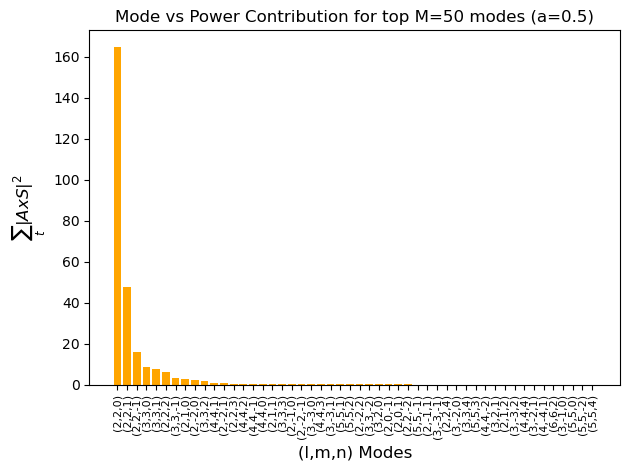

In [86]:
plt.bar(range(len(mp_power)), mp_power, color='orange')
plt.xticks(range(len(mp_modes)), mp_modes, rotation=90, fontsize=8)
plt.xlabel('(l,m,n) Modes', fontsize=12)
plt.ylabel(r'$\sum_{t} |AxS|^2$', fontsize=12)
plt.title('Mode vs Power Contribution for top M={} modes (a={})'.format(M_mode,a), fontsize=12)
plt.yscale('linear')
plt.tight_layout()
plt.show()

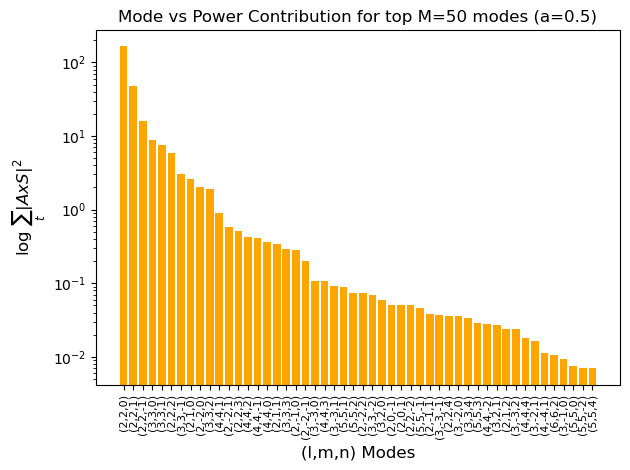

In [87]:
# Bar plot of modes vs approx inner product for top M modes 

plt.bar(range(len(mp_power)), mp_power, color='orange')
plt.xticks(range(len(mp_modes)), mp_modes, rotation=90, fontsize=8)
plt.xlabel('(l,m,n) Modes', fontsize=12)
plt.ylabel(r'log $\sum_{t} |AxS|^2$', fontsize=12)
plt.title('Mode vs Power Contribution for top M={} modes (a={})'.format(M_mode,a), fontsize=12)
plt.yscale('log')
plt.tight_layout()
plt.show()


In [88]:
# Pick modes based on top M power contributions
top_indices = [mode_labels.index(mode) for mode in mp_modes]
print("Top mode indices:", top_indices)


Top mode indices: [1165, 1166, 1164, 1498, 1499, 1167, 1497, 1054, 7159, 1500, 1943, 7160, 1168, 1944, 1941, 1942, 1055, 1501, 7048, 7158, 7492, 1945, 7493, 2498, 2499, 7161, 1496, 1387, 54, 56, 1163, 2496, 7049, 7491, 1169, 7381, 1502, 2500, 1940, 1388, 1056, 7494, 1946, 7382, 7937, 3165, 7270, 2497, 2495, 2501]


 # Approx Inner Product via noise-weighted power

In [89]:
def calc_nw_power(teuk_modes, ylms, m0mask):
    # Calculate power for all modes
    full_modes = np.concatenate([teuk_modes, np.conj(teuk_modes[:, m0mask])], axis=1)
    h_lmn = full_modes * ylms[np.newaxis, :] # (time, modes)
    power = np.abs(h_lmn)**2
    print("Power shape:", power.shape)  # Shape: (N_traj, N_modes)
    # Convert to cpu
    power = power.get()
    
    # Get noise-weighted power for each mode
    nw_power = np.zeros_like(power)
    
    # Iterate through each mode
    for mode_idx in range(power.shape[1]):
        freq_mode = gw_frequencies_per_mode[mode_idx] # change array of gw frequencies here 
        
        # Handle small / zero freq values -> replace with a small threshold
        zero_freq_mask = np.abs(freq_mode) < 1e-6
        freq_gw = np.where(zero_freq_mask, 1e-6, freq_mode)
        
        # Get noise PSD
        Sn_vals = get_sensitivity(freq_gw, sens_fn=LISASens, return_type="PSD")
        
        # Apply noise weighting
        nw_power[:, mode_idx] = power[:, mode_idx] / Sn_vals

    # Sum over trajectory points
    return np.sum(nw_power, axis=0)

In [90]:
nw_power = calc_nw_power(teuk_modes, ylms, m0mask)
print("Noise-weighted inner product through power:", nw_power)

Power shape: (5000, 12987)
Noise-weighted inner product through power: [5.72754746e+00 6.64926547e+01 1.30219777e+01 ... 1.39297150e+06
 1.25520779e+05 1.83708552e+06]


In [91]:
approx_inner = nw_power * delta_T * 1/(factor**2) * 4

In [92]:
# Select nw_power for top modes
top_approx_inner = [approx_inner[i] for i in top_indices]
mode_labels_sel = [mode_labels[i] for i in top_indices]

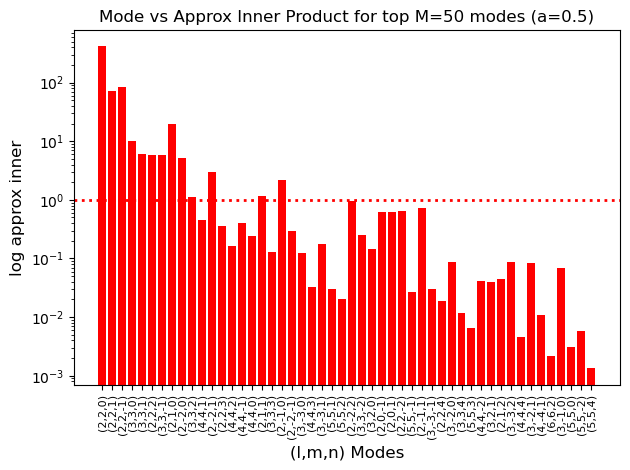

In [93]:
plt.axhline(y=1, color='red', linestyle='dotted', linewidth=2, label='Threshold (Inner Product = 1)')
plt.bar(range(M_mode), top_approx_inner, color='red')
plt.xticks(range(M_mode), mode_labels_sel, rotation=90, fontsize=8)
plt.xlabel('(l,m,n) Modes', fontsize=12)
plt.ylabel(r'log approx inner', fontsize=12)
plt.title('Mode vs Approx Inner Product for top M={} modes (a={})'.format(M_mode,a), fontsize=12)
plt.yscale('log')
plt.tight_layout()
plt.show()


In [94]:
ai = list(zip(mode_labels, approx_inner)) 

# Sort by approx inner product and pick top M modes
ai_sorted = sorted(ai, key=lambda x: x[1], reverse=True)[:M_mode]
ai_modes = [x[0] for x in ai_sorted]
ai_inner = [x[1] for x in ai_sorted]

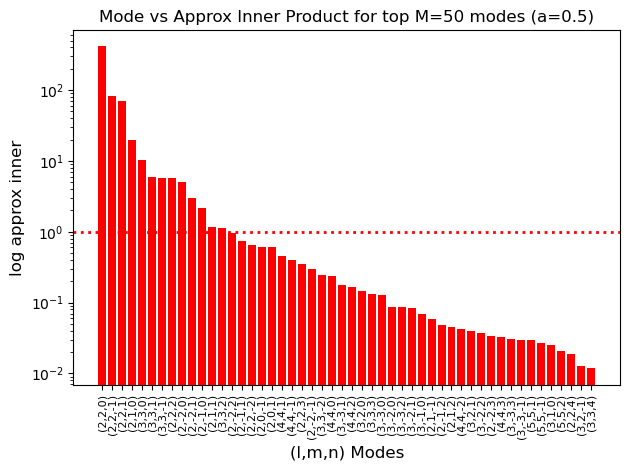

In [95]:
plt.axhline(y=1, color='red', linestyle='dotted', linewidth=2, label='Threshold (Inner Product = 1)')
plt.bar(range(M_mode), ai_inner, color='red')
plt.xticks(range(M_mode), ai_modes, rotation=90, fontsize=8)
plt.xlabel('(l,m,n) Modes', fontsize=12)
plt.ylabel(r'log approx inner', fontsize=12)
plt.title('Mode vs Approx Inner Product for top M={} modes (a={})'.format(M_mode,a), fontsize=12)
plt.yscale('log')
plt.tight_layout()
plt.show()


In [65]:
waveform_per_mode = []
for idx in top_indices:
    l = amp.l_arr[idx]
    m = amp.m_arr[idx]
    n = amp.n_arr[idx]
    print('Mode: ', mode_labels[idx])

    if m >= 0:
        # For m >= 0, directly use the mode
        teuk_modes_single = teuk_modes[:, [idx]]
        ylms_single = ylms[[idx]]
        m_arr = amp.m_arr[[idx]]
    else:
        # Finding corresponding m>0 mode instead of mapping
        print('NEGATIVE M MODE')
        pos_m_mask = (amp.l_arr == l) & (amp.m_arr == -m) & (amp.n_arr == n) 
        print(amp.l_arr[pos_m_mask], amp.m_arr[pos_m_mask], amp.n_arr[pos_m_mask])
        pos_m_idx = np.where(pos_m_mask)[0]
        print(pos_m_idx)
        
        teuk_modes_single = (-1)**l * np.conj(teuk_modes[:, [pos_m_idx]])
        print(teuk_modes_single)
        # ylms_single = (-1)**(-m) * np.conj(ylms[[pos_m_idx]])
        ylms_single = ylms[[idx]]
        print(ylms_single)
        m_arr = np.abs(amp.m_arr[[idx]])  # To pass positive m 

    waveform = interpolate_mode_sum(
        t,
        teuk_modes_single,
        ylms_single,
        traj.integrator_spline_t,
        traj.integrator_spline_phase_coeff[:, [0, 2]],
        amp.l_arr[[idx]], 
        m_arr,  
        amp.n_arr[[idx]], 
        dt=dt,
        T=T
    )
    waveform_per_mode.append(waveform/factor)

Mode:  (2,2,0)


AttributeError: 'numpy.ndarray' object has no attribute 'get'

In [ ]:
# Convert each waveform to frequency domain
hf_per_mode = [gwf.freq_wave(waveform) for waveform in waveform_per_mode]

In [ ]:
mode_labels_sel = [mode_labels[i] for i in top_indices]

In [ ]:
inner_products = []
for i, mode in enumerate(hf_per_mode):
    inner_product = gwf.inner(mode,mode)
    inner_products.append(inner_product)

In [ ]:
plt.figure(figsize=(12, 6))
plt.bar(range(len(inner_products)), inner_products, color='blue')
plt.xticks(range(len(mode_labels_sel)), mode_labels_sel, rotation=90, fontsize=8)
plt.axhline(y=1, color='red', linestyle='dotted', linewidth=2, label='Threshold (Inner Product = 1)')
plt.xlabel('(l,m,n) Modes', fontsize=12)
plt.ylabel(r'$log< h_i|h_i >$', fontsize=12)
plt.title('Mode vs Noise-weighted Inner Product for top M={} modes (a={})'.format(len(inner_products), a), fontsize=12)
plt.yscale('log')
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
def calc_nw_power(teuk_modes, ylms, m0mask):
    # Calculate power for all modes
    full_modes = np.concatenate([teuk_modes, np.conj(teuk_modes[:, m0mask])], axis=1)
    h_lmn = full_modes * ylms[np.newaxis, :] # (time, modes)
    power = np.abs(h_lmn)**2
    print("Power shape:", power.shape)  # Shape: (N_traj, N_modes)
    
    # Get noise-weighted power for each mode
    nw_power = np.zeros_like(power)
    
    # Iterate through each mode
    for mode_idx in range(power.shape[1]):
        freq_mode = alt_gw_frequencies_per_mode[mode_idx] # change array of gw frequencies here 
        
        # Handle small / zero freq values -> replace with a small threshold
        zero_freq_mask = np.abs(freq_mode) < 1e-6
        freq_gw = np.where(zero_freq_mask, 1e-6, freq_mode)
        
        # Get noise PSD
        Sn_vals = get_sensitivity(freq_gw, sens_fn=LISASens, return_type="PSD")
        
        # Apply noise weighting
        nw_power[:, mode_idx] = power[:, mode_idx] / Sn_vals

    # Sum over trajectory points
    return np.sum(nw_power, axis=0)

In [ ]:
teuk_modes.shape

In [ ]:
ylms.shape[0]/2

In [ ]:
nw_power = calc_nw_power(teuk_modes, ylms, m0mask)
print("Noise-weighted inner product through power:", nw_power)

In [ ]:
approx_inner = nw_power * delta_T * 1/(factor**2) * 4

Need factor of 2 or 4 due to *symmetry*?

In [ ]:
# Select nw_power for top modes
top_approx_inner = [approx_inner[i] for i in top_indices]

In [ ]:
plt.axhline(y=1, color='red', linestyle='dotted', linewidth=2, label='Threshold (Inner Product = 1)')
plt.bar(range(M_mode), top_approx_inner, color='red')
plt.xticks(range(M_mode), mode_labels_sel, rotation=90, fontsize=8)
plt.xlabel('(l,m,n) Modes', fontsize=12)
plt.ylabel(r'$\sum_{t} |AxS|^2 dT$', fontsize=12)
plt.title('Mode vs Approx Inner Product for top M={} modes (a={})'.format(M_mode,a), fontsize=12)
plt.yscale('log')
plt.tight_layout()
plt.show()


In [ ]:
plt.figure(figsize=(20, 6))

bar_width = 0.4  
gap = 0.05
x_positions = np.arange(len(mode_labels_sel))
bars1 = plt.bar(x_positions - bar_width/2 - gap/2, top_approx_inner, bar_width,
                color='red', label=r'$\sum_{t} |AxS|^2 dT$')
bars2 = plt.bar(x_positions + bar_width/2 + gap/2, inner_products, bar_width,
                color='blue', label=r'$< h_i|h_i >$')
plt.xticks(x_positions, mode_labels_sel, rotation=90, fontsize=8)
plt.axhline(y=1, color='red', linestyle='dotted', linewidth=2, label='Threshold (Inner Product = 1)')
plt.xlabel('(l,m,n) Modes', fontsize=12)
plt.ylabel(r'$\log_{10} \langle h_i|h_i \rangle$', fontsize=12)
plt.title('Mode vs Inner Product Comparison for top M={} modes (a={})'.format(M_mode, a), fontsize=12)
plt.yscale('log')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(20, 6))

bar_width = 0.4  
gap = 0.05
x_positions = np.arange(len(mode_labels_sel))
bars1 = plt.bar(x_positions - bar_width/2 - gap/2, top_approx_inner, bar_width,
                color='red', label=r'$\sum_{t} |AxS|^2 dT$')
bars2 = plt.bar(x_positions + bar_width/2 + gap/2, inner_products, bar_width,
                color='blue', label=r'$< h_i|h_i >$')
plt.xticks(x_positions, mode_labels_sel, rotation=90, fontsize=8)
plt.axhline(y=1, color='red', linestyle='dotted', linewidth=2, label='Threshold (Inner Product = 1)')
plt.xlabel('(l,m,n) Modes', fontsize=12)
plt.ylabel(r'$log \langle h_i|h_i \rangle$', fontsize=12)
plt.title('Mode vs Inner Product Comparison for top M={} modes (a={})'.format(M_mode, a), fontsize=12)
plt.yscale('log')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
def modeselect_alg(hf_per_mode, inner_products, mode_labels, M_sel, inner_threshold=0.01):
    ##########################################
    ### Step 0: Initialize with strongest mode 
    ##########################################

    # Initialize combination counts
    combination_counts = {
        'rejected_modes': 0,
        'remaining_to_hM': 0, 
        'hM_with_selected': 0,
        'total': 0
    }

    # Track which modes were combined with each selected mode
    combined_modes_tracker = {}

    ## NOTE: I skipped the argsort here since I assume the inner_products are already sorted
    
    # Pick the strongest mode h_0
    sorted_indices = range(0,len(hf_per_mode))
    h0_idx = sorted_indices[0]
    
    # Initialize selected set S with h_0
    selected_modes = [hf_per_mode[h0_idx]]  
    selected_indices = [h0_idx]
    selected_labels = [mode_labels[h0_idx]]

    # Initialize tracking for the first selected mode
    combined_modes_tracker[0] = {'original': mode_labels[h0_idx], 'combined_with': []}

    # Keep track of all processed modes
    # Useful for combining remaining modes into h_M later
    processed_indices = [h0_idx]  
    
    print(f"Step 0: Selected strongest mode h_0: {mode_labels[h0_idx]} with inner product {inner_products[h0_idx]:.4e}")
    
    ###################################################
    # Step 1, 2, ... N: Iterate through remaining modes
    ###################################################  

    # Iterate till N_max to fulfill cond. <h_i|h_i> > 1 
    for i in range(1, len(hf_per_mode)):   
        # Check if we have reached the target number of modes
        if len(selected_modes) >= M_sel:
            print(f"\nReached target of {M_sel} selected modes.")
            break
            
        # Get the next candidate mode h_j'
        hj_prime_idx = sorted_indices[i]
        hj_prime = hf_per_mode[hj_prime_idx]
        processed_indices.append(hj_prime_idx)
        
        print(f"\n--- Iteration {i} ---")
        print(f"Currently have {len(selected_modes)} selected modes, target is {M_sel}")
        print(f"Candidate mode h_j': {mode_labels[hj_prime_idx]} with inner product {inner_products[hj_prime_idx]:.4e}")
        
        # Check max inner product w/ selected modes 
        max_inner = 0
        # Initialize index of mode w/ max inner product
        max_inner_idx = -1  
        
        for k, selected_mode in enumerate(selected_modes):
            # Calculate |<h_selected|h_j'>|
            calc_inner = abs(gwf.inner(selected_mode, hj_prime))
            print(f"  calc_inner with selected mode {k} ({selected_labels[k]}): {calc_inner:.6f}")

            # Update max inner product and index if this is the largest so far
            if calc_inner > max_inner:
                max_inner = calc_inner
                max_inner_idx = k
        
        # Check if max inner prod is below threshold
        if max_inner < inner_threshold:
            # Accept the mode
            selected_modes.append(hj_prime)
            selected_indices.append(hj_prime_idx)
            selected_labels.append(mode_labels[hj_prime_idx])
            
            # Initialize tracking for this new selected mode
            combined_modes_tracker[len(selected_modes)-1] = {
                'original': mode_labels[hj_prime_idx], 
                'combined_with': []
            }
            
            print(f"  ACCEPTED: Max inner product {max_inner:.6f} < {inner_threshold}")
            print(f"  Added mode: {mode_labels[hj_prime_idx]} (Total selected: {len(selected_modes)})")
        else:
            # Reject and add to most correlated mode
            print(f"  REJECTED: Max inner product {max_inner:.6f} >= {inner_threshold}")
            print(f"  Most correlated with: {selected_labels[max_inner_idx]}")
            
            # Track which mode was combined
            combined_modes_tracker[max_inner_idx]['combined_with'].append(mode_labels[hj_prime_idx])
            
            # Add h_j' to the most correlated mode h_k
            selected_modes[max_inner_idx] = selected_modes[max_inner_idx] + hj_prime
            combination_counts['rejected_modes'] += 1
            print(f"  Combined with mode: {selected_labels[max_inner_idx]}")
    
    ##########################################
    # Step N+1: Handle remaining modes as h_M
    ##########################################

    print(f"\n" + "="*50)
    print("STEP 2: Processing remaining modes as h_M")
    print("="*50)
    
    # Find all remaining modes not processed yet
    all_indices = set(range(len(hf_per_mode)))
    remaining_indices = list(all_indices - set(processed_indices))
    
    # Only process if there are remaining modes
    if remaining_indices:
        print(f"There are {len(remaining_indices)} remaining modes to combine into h_M")
        
        # Get labels of remaining modes for tracking
        remaining_mode_labels = [mode_labels[idx] for idx in remaining_indices]
        print(f"Remaining modes: {remaining_mode_labels}")
        
        # Sum all remaining modes to create h_M
        h_M = hf_per_mode[remaining_indices[0]]  
        for idx in remaining_indices[1:]:
            h_M = h_M + hf_per_mode[idx]
            combination_counts['remaining_to_hM'] += 1  
        
        # Check condition 1: <h_M|h_M> > 1 : True/False
        h_M_inner_product = gwf.inner(h_M, h_M)
        cond_one = h_M_inner_product > 1
        print(f"Condition 1: <h_M|h_M> = {h_M_inner_product:.6f} > 1? {cond_one}")
        
        # Check condition 2: <h_i|h_M> << 1 for all selected modes
        # Check inner products with selected modes and get the maximum inner product
        inners_with_selected = []
        max_inner_with_selected = 0
        max_inner_with_selected_idx = -1
        
        for k, selected_mode in enumerate(selected_modes):
            calc_inner = abs(gwf.inner(selected_mode, h_M))
            inners_with_selected.append(calc_inner)
            print(f"  <h_{k}|h_M> = {calc_inner:.6f}")
            
            # Update max inner product and index if this is the largest so far
            if calc_inner > max_inner_with_selected:
                max_inner_with_selected = calc_inner
                max_inner_with_selected_idx = k
        
        # Check if max inner product with selected modes is below threshold
        cond_two = max_inner_with_selected < inner_threshold
        print(f"Condition 2: max inner = {max_inner_with_selected:.6f} < {inner_threshold}? {cond_two}")
        
        # Decision logic
        print(f"\nDecision for h_M:")
        if cond_one and cond_two: # If both conditions are satisfied
            # Accept h_M as an extra mode
            selected_modes.append(h_M)
            selected_indices.append(-1)  # Special index for h_M
            selected_labels.append("h_M (remaining modes)")
            
            # Initialize tracking for h_M
            combined_modes_tracker[len(selected_modes)-1] = {
                'original': 'h_M', 
                'combined_with': remaining_mode_labels
            }
            
            print(f"  ACCEPTED h_M: Both conditions satisfied")
            print(f"  Added h_M as extra mode (Total selected: {len(selected_modes)})")
            
        elif not cond_one and cond_two: # If condition 1 is violated but condition 2 is satisfied
            # Throw away h_M (becomes error term)
            print(f"  DISCARDED h_M: Condition 1 violated, Condition 2 satisfied")
            print(f"  h_M becomes error/epsilon term")
             
        elif cond_one and not cond_two: # If condition 1 is satisfied but condition 2 is violated
            # Add h_M to most correlated selected mode
            print(f"  COMBINED h_M: Condition 1 satisfied, Condition 2 violated")
            print(f"  Most correlated with: {selected_labels[max_inner_with_selected_idx]}")
            
            # Track h_M combination
            combined_modes_tracker[max_inner_with_selected_idx]['combined_with'].extend(remaining_mode_labels)
            
            selected_modes[max_inner_with_selected_idx] = selected_modes[max_inner_with_selected_idx] + h_M
            combination_counts['hM_with_selected'] += 1 
            print(f"  Combined h_M with: {selected_labels[max_inner_with_selected_idx]}")
            
        else:  # If both conditions are violated
            # Throw away h_M
            print(f"  DISCARDED h_M: Both conditions violated")
            print(f"  h_M is thrown away")
    else:
        print("No remaining modes to process as h_M")
    
    if len(selected_modes) >= M_sel:
        print(f"\nReached target of {M_sel} selected modes.")
    else:
        print(f"\nProcessed all modes. Selected {len(selected_modes)} modes.")

    # Calculate total combinations
    combination_counts['total'] = (combination_counts['rejected_modes'] + 
                                  combination_counts['remaining_to_hM'] + 
                                  combination_counts['hM_with_selected'])
    
    ##########################################################
    # Calculate final inner products of selected modes
    ##########################################################
    print(f"\n" + "="*50)
    print("FINAL INNER PRODUCTS OF SELECTED MODES:")
    print("="*50)
    
    final_inner_products = []
    total_final_inner = 0
    
    for i, mode in enumerate(selected_modes):
        final_ip = gwf.inner(mode, mode)
        final_inner_products.append(final_ip)
        total_final_inner += final_ip
        
        # Get combination info for this mode
        mode_info = combined_modes_tracker[i]
        combined_info = ""
        if mode_info['combined_with']:
            combined_info = f" + {len(mode_info['combined_with'])} modes: {mode_info['combined_with']}"
        
        print(f"  <h_{i}|h_{i}> = {final_ip:.6f} | {mode_info['original']}{combined_info}")
    
    print(f"\nTotal final inner product: {total_final_inner:.6f}")
    print(f"Square root of total: {np.sqrt(total_final_inner):.6f}")
    
    ##########################################################
    # Detailed combination breakdown
    ##########################################################
    print(f"\n" + "="*50)
    print("COMBINATION BREAKDOWN:")
    print("="*50)
    
    for i, mode_info in combined_modes_tracker.items():
        if mode_info['combined_with']:
            print(f"Selected mode {i} ({mode_info['original']}):")
            print(f"  Combined with {len(mode_info['combined_with'])} modes: {mode_info['combined_with']}")
        else:
            print(f"Selected mode {i} ({mode_info['original']}): No combinations")
    
    print(f"\n" + "="*50)
    print("COMBINATION SUMMARY:")
    print("="*50)
    print(f"Rejected modes combined: {combination_counts['rejected_modes']}")
    print(f"Remaining modes combined into h_M: {combination_counts['remaining_to_hM']}")
    print(f"h_M combined with selected: {combination_counts['hM_with_selected']}")
    print(f"TOTAL COMBINATIONS: {combination_counts['total']}")
    
    return selected_modes, selected_indices, selected_labels, combination_counts, final_inner_products

In [ ]:
sort_inner_products = sorted(zip(mode_labels_sel, inner_products), key=lambda x: x[1], reverse=True)
mode_labels_ip = [x[0] for x in sort_inner_products]
inner_products_sorted = [x[1] for x in sort_inner_products]

In [ ]:
selected_modes_nw, selected_indices_nw, selected_labels_nw, combination_counts_nw, final_inner_products_nw  = modeselect_alg(
    hf_per_mode, inner_products_sorted, mode_labels_ip, M_sel=20, inner_threshold=0.01
)

In [ ]:
N_fin_ip = len(selected_indices_nw)

In [ ]:
plt.figure(figsize=(12, 8))

# Create bar plot
bars = plt.bar(range(N_fin_ip), final_inner_products_nw, color='blue', alpha=0.7, edgecolor='green', linewidth=0.5)

# Set x-axis labels
plt.xticks(range(N_fin_ip), selected_labels_nw, rotation=45, ha='right', fontsize=10)
plt.axhline(y=1, color='red', linestyle='dotted', linewidth=2, label='Threshold (Inner Product = 1)')

       

plt.yscale('log')  # Log scale for better visibility
plt.xlabel('Modes')
plt.ylabel(r'$< h_i|h_i >$')
plt.title(f'Top {N_fin_ip} Modes by Noise-weighted Inner Product (Log Scale) with Selected Modes')
plt.tight_layout()
# plt.legend()
plt.grid(True, alpha=0.3, axis='y')  # Add horizontal grid lines
plt.show()

# STILL NEED TO FIX: New algorithm with power contribution

In [97]:
def calc_inner_power(mode_i, mode_j, teuk_modes, amp, freqs, phases, delta_T, factor):
    total_inner = 0.0
    for idx_i in mode_i:
        for idx_j in mode_j:
            # Obtain the lmn-s
            l_i = amp.l_arr[idx_i]
            m_i = amp.m_arr[idx_i]
            n_i = amp.n_arr[idx_i]
        
            l_j = amp.l_arr[idx_j]
            m_j = amp.m_arr[idx_j]
            n_j = amp.n_arr[idx_j]
        
            # Get Teukolsky modes
            # Check if negative m 
            if m_i >= 0:
                A_i = teuk_modes[:, idx_i]
        
            elif m_i < 0:
                pos_m_mask_i = (amp.l_arr == l_i) & (amp.m_arr == -m_i) & (amp.n_arr == n_i)
                pos_m_idx_i = np.where(pos_m_mask_i)[0][0]
                A_i_pos = teuk_modes[:, pos_m_idx_i]
                A_i = (-1)**l_i * np.conj(A_i_pos)
        
            if m_j >= 0:
                A_j = teuk_modes[:, idx_j]
                
            elif m_j < 0:
                pos_m_mask_j = (amp.l_arr == l_j) & (amp.m_arr == -m_j) & (amp.n_arr == n_j)
                pos_m_idx_j = np.where(pos_m_mask_j)[0][0]
                A_j_pos = teuk_modes[:, pos_m_idx_j]
                A_j = (-1)**l_j * np.conj(A_j_pos)
        
            # Get sensitivity for each mode 
            Sn_i = get_sensitivity(freqs[idx_i], sens_fn=LISASens, return_type="PSD")
            Sn_j = get_sensitivity(freqs[idx_j], sens_fn=LISASens, return_type="PSD")
        
            # Get noise-weighted amplitudes
            bar_A_i = A_i.get() / np.sqrt(Sn_i)
            bar_A_j = A_j.get() / np.sqrt(Sn_j)
        
            # Get phase mask
            phase_mask = np.abs(phases[idx_i] - phases[idx_j]) < 1.0 
        
            # Calculate product
            prod = np.conj(bar_A_i[phase_mask]) * bar_A_j[phase_mask]
        
            # Calculate full inner product
            innerprod = np.sum(np.real(prod)) * delta_T * 1/(factor**2)

            total_inner += innerprod

    return total_inner

In [98]:
calc_inner_power([1165],[1165, 1166], teuk_modes, amp, gw_frequencies_per_mode, gw_phase_per_mode, delta_T, factor)

np.float64(819.2489239699922)

In [96]:
for i in range(len(top_indices)):
    print("=== Calculating for mode:", mode_labels[top_indices[i]])
    print("Calc_inner_power:", calc_inner_power([top_indices[i]], [top_indices[i]], teuk_modes, amp, gw_frequencies_per_mode, gw_phase_per_mode, delta_T, factor))

=== Calculating for mode: (2,2,0)
Time-domain: 819.1758061762276
=== Calculating for mode: (2,2,1)
Time-domain: 139.90582012947377
=== Calculating for mode: (2,2,-1)
Time-domain: 164.0671477687492
=== Calculating for mode: (3,3,0)
Time-domain: 12.914471747046804
=== Calculating for mode: (3,3,1)
Time-domain: 7.548718464803215
=== Calculating for mode: (2,2,2)
Time-domain: 11.431441377274345
=== Calculating for mode: (3,3,-1)
Time-domain: 7.325888156728286
=== Calculating for mode: (2,1,0)
Time-domain: 28.961556586231442
=== Calculating for mode: (2,-2,0)
Time-domain: 819.1758061762276
=== Calculating for mode: (3,3,2)
Time-domain: 1.4131201782786706
=== Calculating for mode: (4,4,1)
Time-domain: 0.5041597865818781
=== Calculating for mode: (2,-2,1)
Time-domain: 484.959743537937
=== Calculating for mode: (2,2,3)
Time-domain: 0.7006125172730453
=== Calculating for mode: (4,4,2)
Time-domain: 0.18583669759031574
=== Calculating for mode: (4,4,-1)
Time-domain: 0.4540602296899006
=== Calcula

In [101]:
def modeselect_alg_power(power_values, mode_labels, teuk_modes, ylms, m0mask, delta_T, factor, gw_frequencies_per_mode, gw_phase_per_mode, amp, original_mode_labels, M_sel=10, inner_threshold=0.01):
    ##########################################
    ### Step 0: Initialize with strongest mode 
    ##########################################

    # Initialize combination counts
    combination_counts = {
        'rejected_modes': 0,
        'remaining_to_hM': 0, 
        'hM_with_selected': 0,
        'total': 0
    }

    # Track which modes were combined with each selected mode
    combined_modes_tracker = {}

    # Create mapping from sorted mode labels to original indices
    mode_label_to_original_idx = {label: idx for idx, label in enumerate(original_mode_labels)}
    
    # Pick the strongest mode h_0
    h0_label = mode_labels[0]
    h0_original_idx = mode_label_to_original_idx[h0_label]
    
    # Initialize selected set S with h_0
    selected_modes = [[h0_original_idx]] # Each element is a list of original mode indices
    selected_indices = [0]  # Index in the sorted list
    selected_labels = [h0_label]

    # Initialize tracking for the first selected mode
    combined_modes_tracker[0] = {'original': h0_label, 'combined_with': []}

    # Keep track of all processed modes (using sorted indices)
    processed_indices = [0]  
    
    print(f"Step 0: Selected strongest mode h_0: {h0_label} with power value {power_values[0]:.4e}")
    print("Using power inner product calculation.")
    h0_inner = calc_inner_power([h0_original_idx], [h0_original_idx], teuk_modes, amp, gw_frequencies_per_mode, gw_phase_per_mode, delta_T, factor)
    print(f"Inner product: {h0_inner:.6f}")
    
    ###################################################
    # Step 1, 2, ... N: Iterate through remaining modes
    ###################################################  

    # Iterate till N_max to fulfill cond. <h_i|h_i> > 1 
    for i in range(1, len(power_values)):   
        # Check if we have reached the target number of modes
        if len(selected_modes) >= M_sel:
            print(f"\nReached target of {M_sel} selected modes.")
            break
            
        # Get the next candidate mode h_j'
        hj_prime_label = mode_labels[i]
        hj_prime_original_idx = mode_label_to_original_idx[hj_prime_label]
        processed_indices.append(i)
        
        print(f"\n--- Iteration {i} ---")
        print(f"Currently have {len(selected_modes)} selected modes, target is {M_sel}")
        print(f"Candidate mode h_j': {hj_prime_label} with power value {power_values[i]:.4e}")
        
        # Check max inner product w/ selected modes 
        max_inner = 0
        # Initialize index of mode w/ max inner product
        max_inner_idx = -1  
        
        for k, selected_mode in enumerate(selected_modes):
            # Calculate |<h_selected|h_j'>|
            print(f"  Calculating inner product with selected mode", selected_mode, "and hj_prime_idx:", hj_prime_original_idx)
            # Use calc_power_inner to get the inner product
            cross_term_inner = calc_inner_power(selected_mode, [hj_prime_original_idx], teuk_modes, amp, gw_frequencies_per_mode, gw_phase_per_mode, delta_T, factor)
            self_selmode_inner = calc_inner_power(selected_mode, selected_mode, teuk_modes, amp, gw_frequencies_per_mode, gw_phase_per_mode, delta_T, factor)
            self_hjprime_inner = calc_inner_power([hj_prime_original_idx], [hj_prime_original_idx], teuk_modes, amp, gw_frequencies_per_mode, gw_phase_per_mode, delta_T, factor)
            calc_inner = abs(cross_term_inner/ np.sqrt(self_selmode_inner * self_hjprime_inner))
            print(calc_inner)
            print(f"  calc_inner with selected mode {k} ({selected_labels[k]}): {calc_inner:.6f}")

            # Update max inner product and index if this is the largest so far
            if calc_inner > max_inner:
                max_inner = calc_inner
                max_inner_idx = k
        
        # Check if max inner prod is below threshold
        if max_inner < inner_threshold:
            # Accept the mode
            selected_modes.append([hj_prime_original_idx])  # Store as a list of original indices
            selected_indices.append(i)  # Store sorted index
            selected_labels.append(hj_prime_label)
            
            # Initialize tracking for this new selected mode
            combined_modes_tracker[len(selected_modes)-1] = {
                'original': hj_prime_label, 
                'combined_with': []
            }
            
            print(f"  ACCEPTED: Max inner product {max_inner:.6f} < {inner_threshold}")
            print(f"  Added mode: {hj_prime_label} (Total selected: {len(selected_modes)})")
        else:
            # Reject and add to most correlated mode
            print(f"  REJECTED: Max inner product {max_inner:.6f} >= {inner_threshold}")
            print(f"  Most correlated with: {selected_labels[max_inner_idx]}")
            
            # Track which mode was combined
            combined_modes_tracker[max_inner_idx]['combined_with'].append(hj_prime_label)
            
            # Add h_j' to the most correlated mode h_k
            selected_modes[max_inner_idx].append(hj_prime_original_idx)
            combination_counts['rejected_modes'] += 1
            print(f"  Combined with mode: {selected_labels[max_inner_idx]}")
    
    ##########################################
    # Step N+1: Handle remaining modes as h_M
    ##########################################

    print(f"\n" + "="*50)
    print("STEP 2: Processing remaining modes as h_M")
    print("="*50)
    
    # Find all remaining modes not processed yet (using sorted indices)
    all_sorted_indices = set(range(len(power_values)))
    remaining_sorted_indices = list(all_sorted_indices - set(processed_indices))
    
    # Only process if there are remaining modes
    if remaining_sorted_indices:
        print(f"There are {len(remaining_sorted_indices)} remaining modes to combine into h_M")
        
        # Convert to original indices and get labels
        remaining_original_indices = [mode_label_to_original_idx[mode_labels[idx]] for idx in remaining_sorted_indices]
        remaining_mode_labels = [mode_labels[idx] for idx in remaining_sorted_indices]
        print(f"Remaining modes: {remaining_mode_labels}")
        
        # Count combinations for h_M creation
        combination_counts['remaining_to_hM'] += len(remaining_original_indices) - 1
        
        # Check condition 1: <h_M|h_M> > 1 : True/False
        h_M_inner_product = calc_inner_power(remaining_original_indices, remaining_original_indices, teuk_modes, amp, gw_frequencies_per_mode, gw_phase_per_mode, delta_T, factor)
        cond_one = h_M_inner_product > 1
        print(f"Condition 1: <h_M|h_M> = {h_M_inner_product:.6f} > 1? {cond_one}")
        
        # Check condition 2: <h_i|h_M> << 1 for all selected modes
        # Check inner products with selected modes and get the maximum inner product
        inners_with_selected = []
        max_inner_with_selected = 0
        max_inner_with_selected_idx = -1
        
        for k, selected_mode in enumerate(selected_modes):
            calc_inner = calc_inner_power(selected_mode, remaining_original_indices, teuk_modes, amp, gw_frequencies_per_mode, gw_phase_per_mode, delta_T, factor)
            inners_with_selected.append(calc_inner)
            print(f"  <h_{k}|h_M> = {calc_inner:.6f}")
            
            # Update max inner product and index if this is the largest so far
            if calc_inner > max_inner_with_selected:
                max_inner_with_selected = calc_inner
                max_inner_with_selected_idx = k
        
        # Check if max inner product with selected modes is below threshold
        cond_two = max_inner_with_selected < inner_threshold
        print(f"Condition 2: max inner = {max_inner_with_selected:.6f} < {inner_threshold}? {cond_two}")
        
        # Decision logic
        print(f"\nDecision for h_M:")
        if cond_one and cond_two: # If both conditions are satisfied
            # Accept h_M as an extra mode
            selected_modes.append(remaining_original_indices)
            selected_indices.append(-1)  # Special index for h_M
            selected_labels.append("h_M (remaining modes)")
            
            # Initialize tracking for h_M
            combined_modes_tracker[len(selected_modes)-1] = {
                'original': 'h_M', 
                'combined_with': remaining_mode_labels
            }
            
            print(f"  ACCEPTED h_M: Both conditions satisfied")
            print(f"  Added h_M as extra mode (Total selected: {len(selected_modes)})")
            
        elif not cond_one and cond_two: # If condition 1 is violated but condition 2 is satisfied
            # Throw away h_M (becomes error term)
            print(f"  DISCARDED h_M: Condition 1 violated, Condition 2 satisfied")
            print(f"  h_M becomes error/epsilon term")
             
        elif cond_one and not cond_two: # If condition 1 is satisfied but condition 2 is violated
            # Add h_M to most correlated selected mode
            print(f"  COMBINED h_M: Condition 1 satisfied, Condition 2 violated")
            print(f"  Most correlated with: {selected_labels[max_inner_with_selected_idx]}")
            
            # Track h_M combination
            combined_modes_tracker[max_inner_with_selected_idx]['combined_with'].extend(remaining_mode_labels)
            
            selected_modes[max_inner_with_selected_idx].extend(remaining_original_indices)
            combination_counts['hM_with_selected'] += 1 
            print(f"  Combined h_M with: {selected_labels[max_inner_with_selected_idx]}")
            
        else:  # If both conditions are violated
            # Throw away h_M
            print(f"  DISCARDED h_M: Both conditions violated")
            print(f"  h_M is thrown away")
    else:
        print("No remaining modes to process as h_M")
    
    if len(selected_modes) >= M_sel:
        print(f"\nReached target of {M_sel} selected modes.")
    else:
        print(f"\nProcessed all modes. Selected {len(selected_modes)} modes.")

    # Calculate total combinations
    combination_counts['total'] = (combination_counts['rejected_modes'] + 
                                  combination_counts['remaining_to_hM'] + 
                                  combination_counts['hM_with_selected'])
    
    ##########################################################
    # Calculate final inner products of selected modes
    ##########################################################
    print(f"\n" + "="*50)
    print("FINAL INNER PRODUCTS OF SELECTED MODES:")
    print("="*50)
    
    final_inner_products = []
    total_final_inner = 0
    
    for i, mode in enumerate(selected_modes):
        final_ip = calc_inner_power(mode, mode, teuk_modes, amp, gw_frequencies_per_mode, gw_phase_per_mode, delta_T, factor)
        final_inner_products.append(final_ip)
        total_final_inner += final_ip
        
        # Get combination info for this mode
        mode_info = combined_modes_tracker[i]
        combined_info = ""
        if mode_info['combined_with']:
            combined_info = f" + {len(mode_info['combined_with'])} modes: {mode_info['combined_with']}"
        
        print(f"  <h_{i}|h_{i}> = {final_ip:.6f} | {mode_info['original']}{combined_info}")
    
    print(f"\nTotal final inner product: {total_final_inner:.6f}")
    print(f"Square root of total: {np.sqrt(total_final_inner):.6f}")
    
    ##########################################################
    # Detailed combination breakdown
    ##########################################################
    print(f"\n" + "="*50)
    print("COMBINATION BREAKDOWN:")
    print("="*50)
    
    for i, mode_info in combined_modes_tracker.items():
        if mode_info['combined_with']:
            print(f"Selected mode {i} ({mode_info['original']}):")
            print(f"  Combined with {len(mode_info['combined_with'])} modes: {mode_info['combined_with']}")
        else:
            print(f"Selected mode {i} ({mode_info['original']}): No combinations")
    
    print(f"\n" + "="*50)
    print("COMBINATION SUMMARY:")
    print("="*50)
    print(f"Rejected modes combined: {combination_counts['rejected_modes']}")
    print(f"Remaining modes combined into h_M: {combination_counts['remaining_to_hM']}")
    print(f"h_M combined with selected: {combination_counts['hM_with_selected']}")
    print(f"TOTAL COMBINATIONS: {combination_counts['total']}")
    
    return selected_modes, selected_indices, selected_labels, combination_counts, final_inner_products

In [102]:
selected_modes, selected_indices, selected_labels, combination_counts, final_inner_products = modeselect_alg_power(
    mp_power, mp_modes, teuk_modes, ylms, m0mask, delta_T, factor, gw_frequencies_per_mode, gw_phase_per_mode, amp, mode_labels, M_sel=10, inner_threshold=0.01
)

Step 0: Selected strongest mode h_0: (2,2,0) with power value 1.6475e+02
Using power inner product calculation.
Inner product: 819.175806

--- Iteration 1 ---
Currently have 1 selected modes, target is 10
Candidate mode h_j': (2,2,1) with power value 4.7661e+01
  Calculating inner product with selected mode [1165] and hj_prime_idx: 1166
0.0002159815378783394
  calc_inner with selected mode 0 ((2,2,0)): 0.000216
  ACCEPTED: Max inner product 0.000216 < 0.01
  Added mode: (2,2,1) (Total selected: 2)

--- Iteration 2 ---
Currently have 2 selected modes, target is 10
Candidate mode h_j': (2,2,-1) with power value 1.6150e+01
  Calculating inner product with selected mode [1165] and hj_prime_idx: 1164
0.00021444028281886342
  calc_inner with selected mode 0 ((2,2,0)): 0.000214
  Calculating inner product with selected mode [1166] and hj_prime_idx: 1164
0.00023150601288944242
  calc_inner with selected mode 1 ((2,2,1)): 0.000232
  ACCEPTED: Max inner product 0.000232 < 0.01
  Added mode: (2,2

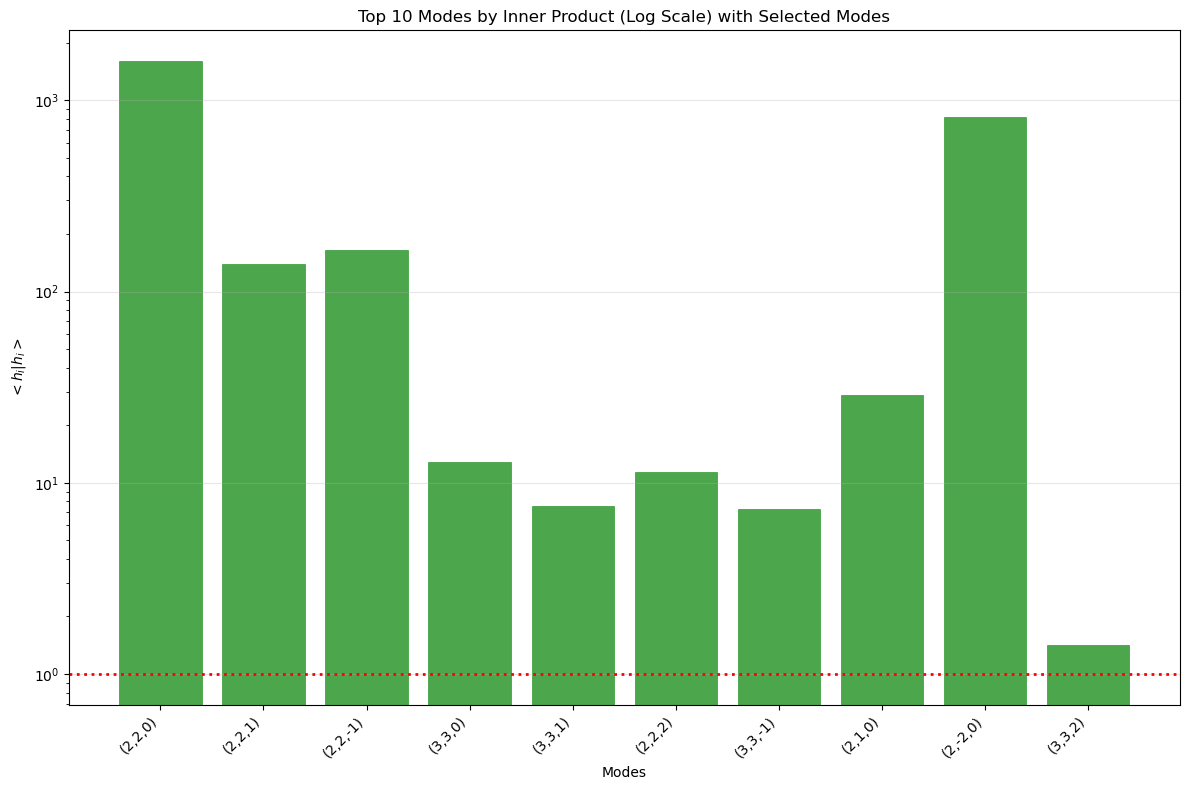

In [103]:
N_fin = len(selected_indices)
plt.figure(figsize=(12, 8))

# Create bar plot
bars = plt.bar(range(N_fin), final_inner_products, color='green', alpha=0.7, edgecolor='green', linewidth=0.5)

# Set x-axis labels
plt.xticks(range(N_fin), selected_labels, rotation=45, ha='right', fontsize=10)
plt.axhline(y=1, color='red', linestyle='dotted', linewidth=2, label='Threshold (Inner Product = 1)')

       

plt.yscale('log')  # Log scale for better visibility
plt.xlabel('Modes')
plt.ylabel(r'$< h_i|h_i >$')
plt.title(f'Top {N_fin} Modes by Inner Product (Log Scale) with Selected Modes')
plt.tight_layout()
# plt.legend()
plt.grid(True, alpha=0.3, axis='y')  # Add horizontal grid lines
plt.show()

In [109]:
def SNR_approx(mode_idx, teuk_modes, amp, gw_frequencies_per_mode, gw_phase_per_mode, delta_T, factor):
    return np.sqrt(calc_inner_power(mode_idx, mode_idx, teuk_modes, amp, gw_frequencies_per_mode, gw_phase_per_mode, delta_T, factor))

In [110]:
SNR_approx([1165], teuk_modes, amp, gw_frequencies_per_mode, gw_phase_per_mode, delta_T, factor)

np.float64(28.621247460168952)

In [113]:
#calc_inner_power([1165],[1165, 1166], teuk_modes, amp, gw_frequencies_per_mode, gw_phase_per_mode, delta_T, factor)
def overlap_approx(mode_i, mode_j, teuk_modes, amp, gw_frequencies_per_mode, gw_phase_per_mode, delta_T, factor):
    SNR_i = SNR_approx(mode_i, teuk_modes, amp, gw_frequencies_per_mode, gw_phase_per_mode, delta_T, factor)
    SNR_j = SNR_approx(mode_j, teuk_modes, amp, gw_frequencies_per_mode, gw_phase_per_mode, delta_T, factor)

    cross_inner = calc_inner_power(mode_i, mode_j, teuk_modes, amp, gw_frequencies_per_mode, gw_phase_per_mode, delta_T, factor)
    overlap = cross_inner / (SNR_i * SNR_j)
    return overlap

In [114]:
Mo = len(selected_modes)

inner_M = np.zeros((Mo, Mo))
overlap_M = np.zeros((Mo, Mo))

for i in range(Mo):
    for j in range(Mo):
        mode_i = selected_modes[i]
        mode_j = selected_modes[j]
        
        overlap_M[i, j] = overlap_approx(mode_i, mode_j, teuk_modes, amp, gw_frequencies_per_mode, gw_phase_per_mode, delta_T, factor)

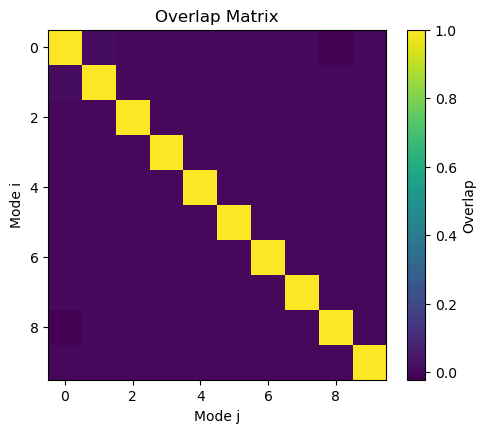

In [115]:
# Plot overlap matrix
plt.figure(figsize=(12, 10))
plt.subplot(2, 2, 1)
im1 = plt.imshow(overlap_M, cmap='viridis', aspect='auto')
plt.colorbar(im1, label='Overlap')
plt.title('Overlap Matrix')
plt.xlabel('Mode j')
plt.ylabel('Mode i')
plt.show()